# Data cleaning and description for DengAI: Predicting Disease Spread data competition


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

features_train = pd.read_csv('../Data/dengue_features_train.csv')
labels_train = pd.read_csv('../Data/dengue_labels_train.csv')
features_train.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


# Cases
## cases x year

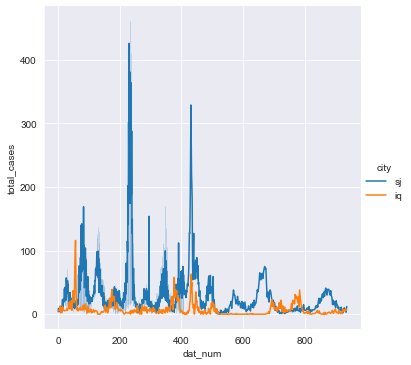

In [2]:
labels = labels_train.sort_values(['year', 'weekofyear'])
labels['dat_num'] = list(range(1, len(labels.loc[labels.city == 'sj'])+1)) + list(range(1, len(labels.loc[labels.city == 'iq'])+1))
sns.relplot(y='total_cases', x='dat_num', hue='city', kind='line', data=labels)

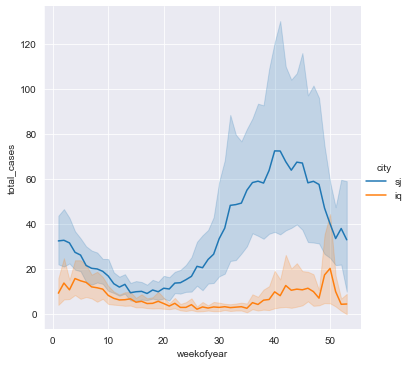

In [3]:
sns.relplot(x='weekofyear', y='total_cases', hue='city', kind='line', data=labels_train)


# Variables


## City and Date Indicators
|---------------| ----------- |
| city          | City abbreviations: sj for San Juan and iq for Iquitos       |
| weekofyear    | International Organization for Standardization (ISO) ordinal weeks of the year        |
| week_start_date| Date given in yyyy-mm-dd format        |


## National Oceanic and Atmospheric Administration (NOAA) Climate Data Records Satellite vegetation - Normalized difference vegetation index (NVDI)
(0.5x0.5 degree scale) measurements

|-------------|----------------------------------|
| ndvi_nw     | Pixel northwest of city centroid |
| ndvi_ne     | Pixel northeast of city centroid |
| ndvi_se     | Pixel southeast of city centroid |
| ndvi_sw     | Pixel southwest of city centroid |

## Precipitation Estimation from Remotely Sensed Information using Artificial Neural Networks - Climate Data Records

|--------------------------| ----------- |
| precipitation_amt_mm     | Total precipitation        |

## NOAA National Centers for Environmental Prediction (NCEP) Climate Forecast System Reanalysis
measurements (0.5x0.5 degree scale)

|---------------| ----------- |
| reanalysis_air_temp_k     | Mean air temperature      |
| reanalysis_avg_temp_k     | Average air temperature        |
| reanalysis_dew_point_temp_k     | Mean dew point temperature    |
| reanalysis_max_air_temp_k     | Maximum air temperature        |
| reanalysis_min_air_temp_k     | Minimum air temperature        |
| reanalysis_precip_amt_kg_per_m2     | Total precipitation        |
| reanalysis_relative_humidity_percent     | Mean relative humidity        |
| reanalysis_sat_precip_amt_mm     | Total precipitation        |
| reanalysis_specific_humidity_g_per_kg     | Mean specific humidity        |
| reanalysis_tdtr_k     | Diurnal temperature range        |


## NOAA's Global Historical Climatology Network daily climate data weather station measurements
|---------------| ----------- |
| station_avg_temp_c     | Average temperature   |
| station_diur_temp_rng_c     | Diurnal temperature range        |
| station_max_temp_c     | Maximum temperature        |
| station_min_temp_c     | Minimum temperature     |
| station_precip_mm     | Total precipitation        |


# Missing Data
Data may be missing in a systematic way that is meaningful, so we will include missing data as a possible predictor

## K-Neighest Neighbors Imputation

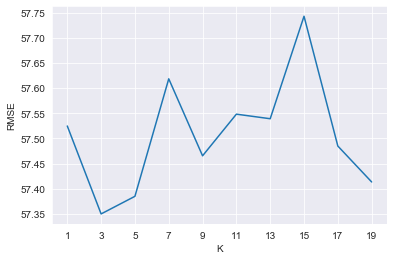

In [3]:
# optimize K
rmse = lambda y, yhat: np.sqrt(mean_squared_error(y, yhat))
def optimize_k(data, target):
    '''
    This function returns the RMSE of predictions from random forest regression at each level of K used to impute missing data

    :param data: dataframe of variables with missing data
    :param target: Pandas Series that K should be optimized to predict
    :return: a dictionary of K and the RMSE at the K in predicting the target
    '''
    if len(data.shape) == 1:
        data = data.to_numpy().reshape(-1,1)

    errors = {'K':[], 'RMSE':[]}
    for k in range(1, 20, 2):
        imputer = KNNImputer(n_neighbors=k)
        imputed = imputer.fit_transform(data)
        df_imputed = pd.DataFrame(imputed)

        x = df_imputed#.drop(target, axis=1)
        y = target #df_imputed[target]
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

        model = RandomForestRegressor()
        model.fit(x_train,y_train)
        preds = model.predict(x_test)
        error = rmse(y_test, preds)
        errors['K'].append(k)
        errors['RMSE'].append(error)
    return errors

NVDI_vars = ['ndvi_ne', 'ndvi_nw','ndvi_se', 'ndvi_sw']
NCEP_vars = ['reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
             'reanalysis_precip_amt_kg_per_m2', 'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm', 'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k']
GHCN_vars = ['station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c', 'station_precip_mm']
satelite_vars = ['precipitation_amt_mm']
vars_to_impute = NVDI_vars + NCEP_vars + GHCN_vars + satelite_vars

df_k = pd.DataFrame(optimize_k(data=features_train['ndvi_ne'], target=labels_train['total_cases']))
df_k['K'] = df_k.astype(str)
sns.lineplot(x='K', y='RMSE', data=df_k)

We optimized for K within variables collected per site.

In [4]:
for cit in features_train.city.unique():
    for site in tqdm([NVDI_vars, NCEP_vars, GHCN_vars, satelite_vars]):
        df_k = pd.DataFrame(optimize_k(data=features_train.loc[features_train.city == cit, site], target=labels_train.loc[labels_train.city == cit, 'total_cases']))
        k = df_k.loc[df_k['RMSE'].idxmin()]['K']
        imputer = KNNImputer(n_neighbors=int(k), weights="distance", add_indicator=True)
        features_train.loc[features_train.city== cit,  site + [vv+'_miss' for vv in site]] = imputer.fit_transform(features_train.loc[labels_train.city == cit, site])

100%|██████████| 4/4 [00:08<00:00,  2.04s/it]


In [5]:
features_train.to_csv('../Data/feature_train_clean_Knn.csv', sep=',')

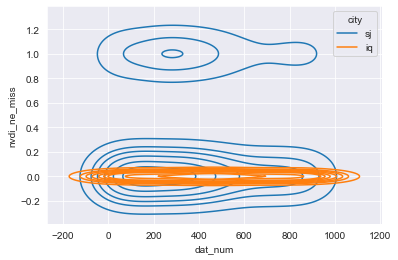

In [23]:
features_train['nvdi_ne_miss'] = features_train.ndvi_ne_miss.astype(bool)
sns.kdeplot(x='dat_num', y='nvdi_ne_miss', hue='city', data=features_train)


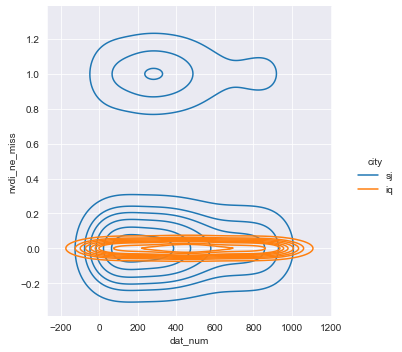

In [25]:
sns.displot(data=features_train, x='dat_num', y='nvdi_ne_miss', hue='city', kind='kde')